In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Helper Functions

In [2]:
##helper function for x directional gradient
def sobelx_binary(img,sobel_kernel=3,x_thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    x_binary =  np.zeros_like(scaled_sobelx)
    x_binary[(scaled_sobelx >= x_thresh[0]) & (scaled_sobelx <= x_thresh[1])] = 1
    return x_binary

In [3]:
##helper function for gradient thresholding
def gradient_thresh(img,sobel_kernel=3,
                    x_thresh=(0,255),
                    y_thresh=(0,255),
                    mag_thresh=(0,255),
                    dir_thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #directional gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    x_binary =  np.zeros_like(scaled_sobelx)
    x_binary[(scaled_sobelx >= x_thresh[0]) & (scaled_sobelx <= x_thresh[1])] = 1
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    y_binary =  np.zeros_like(scaled_sobely)
    y_binary[(scaled_sobely >= y_thresh[0]) & (scaled_sobely <= y_thresh[1])] = 1
    
    #magnitude gradient
    mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobelmag = np.uint8(255*mag/np.max(mag))
    mag_binary = np.zeros_like(scaled_sobelmag)
    mag_binary[(scaled_sobelmag >= mag_thresh[0]) & (scaled_sobelmag <= mag_thresh[1])] = 1
    
    #direction gradient
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    #combine
    res = np.zeros_like(dir_binary)
    res[((x_binary == 1) & (y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return res

In [4]:
def color_threshold(img, thresh=(0, 255)):    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

In [23]:
def warp (img):
    img_size = (img.shape[1],img.shape[0])
    src = np.float32(
        [[140,719],
         [1220,719],
         [780,480],
         [540,480]])
    
    dst = np.float32(
        [[240,719],
         [1040,719],
         [1040,300],
         [240,300]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    
    return warped,M_inv

In [6]:
def locate_lines(img, window_width = 120, window_height = 40):
    left_line = np.zeros_like(img)
    right_line = np.zeros_like(img)    
    windows_img = np.copy(img)
    
    #find the starting points for left and right lines
    midpoint = img.shape[1]/2
    histogram = np.sum(img[img.shape[0]/3*2:,:], axis=0)
    left_x = np.argmax(histogram[:midpoint])
    right_x = np.argmax(histogram[midpoint:])+midpoint
    y = img.shape[0]
    peek_left,peek_right = 0,0
    
    #identify the lines
    for i in range(int(img.shape[0]/window_height)):
        #left window
        left_window = img[y-window_height:y,left_x-window_width/2:left_x+window_width/2]
        #draw the box
        #cv2.rectangle(windows_img,
        #              (int(left_x-window_width/2),y),(int(left_x+window_width/2),y-window_height),
        #              (1),thickness=(4))
        left_line[y-window_height:y,left_x-window_width/2:left_x+window_width/2] = left_window
        
        histogram_left = np.sum(left_window, axis=0)  
        
        if np.sum(histogram_left) == 0:
            peek_left = window_width/2
        else:    
            peek_left = np.argmax(histogram_left)
         
        #right window
        right_window = img[y-window_height:y,right_x-window_width/2:right_x+window_width/2]
        #draw the box
        #cv2.rectangle(windows_img,
        #              (int(right_x-window_width/2),y),(int(right_x+window_width/2),y-window_height),
        #              (1),thickness=(4))
        right_line[y-window_height:y,right_x-window_width/2:right_x+window_width/2] = right_window

        histogram_right = np.sum(right_window, axis=0)
        
        if np.sum(histogram_right) == 0:
            peek_right = window_width/2
        else:    
            peek_right = np.argmax(histogram_right)

        #update left_x, right_x, y
        left_x = left_x - (window_width/2-peek_left)
        right_x = right_x - (window_width/2-peek_right)
        y = y - window_height

    return left_line, right_line

In [7]:
def polyfit(left_line,right_line):
    #get the x values from left_line and right_line for corresponding y values
    yvals = np.linspace(0, 100, num=101)*7.19
    leftx = np.array([np.average(np.nonzero(left_line[elem])) for idx, elem in enumerate(yvals)])
    rightx = np.array([np.average(np.nonzero(right_line[elem])) for idx, elem in enumerate(yvals)])

    #polyfit left line
    idx_l = np.isfinite(leftx) #clean the nan data
    left_fit = np.polyfit(yvals[idx_l], leftx[idx_l], 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    #polyfit right line
    idx_r = np.isfinite(rightx)
    right_fit = np.polyfit(yvals[idx_r], rightx[idx_r], 2)
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

    #calculate curvature in meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    y_eval = np.max(yvals)

    left_fit_cr = np.polyfit(yvals[idx_l]*ym_per_pix, leftx[idx_l]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(yvals[idx_r]*ym_per_pix, rightx[idx_r]*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
    
    #y_eval = np.max(yvals)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
    #                         /np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
    #                            /np.absolute(2*right_fit[0])
       
    return left_fitx,right_fitx,yvals,left_curverad,right_curverad

In [8]:
def moving_avg(xvals, n=3):
    if len(xvals) <= n:
        a = np.cumsum(xvals[1:],axis=0)[-1]
        res = a/(len(xvals)-1)
    else:
        a = np.cumsum(xvals[-n:],axis=0)[-1]
        res = a/n
    return res

## Pipline

In [9]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.recent_xfitted = [] 
        #radius of curvature of the line
        self.radius_of_curvature = [] 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #x values for all fitted x 
        self.allx = np.zeros((101))

In [31]:
def process_frame(frame):  
    global left_line
    global right_line
    
    #x-direction gradient thresholding
    x_binary = sobelx_binary(frame,3,(40,100))
    
    #HLS color thresholding
    s_binary = color_threshold(frame, thresh=(170, 255))
    
    #combined thresholding
    final_binary = np.zeros_like(x_binary) 
    final_binary[(x_binary==1) | (s_binary==1)] = 1
    #warp_zero = np.copy(final_binary).astype(np.uint8)*255
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #perspective transform
    warped,M_inv = warp(final_binary)
    
    #locate the lines      
    left_line_pixels,right_line_pixels = locate_lines(warped, window_width = 120, window_height = 40)
    
    #polyfit
    left_fitx,right_fitx,yvals,l_curv,r_curv, = polyfit(left_line_pixels,right_line_pixels)

    left_line.recent_xfitted = moving_avg(left_line.allx)
    right_line.recent_xfitted = moving_avg(right_line.allx)
                                          
    if np.amax(left_line.allx) == 0:
        left_line.allx = np.vstack([left_line.allx,[left_fitx]])
        left_line.radius_of_curvature.append(l_curv) 
    elif np.amax(left_fitx)-80 < np.amax(left_line.recent_xfitted) and\
         np.amin(left_fitx)+80 > np.amin(left_line.recent_xfitted):
        left_line.allx = np.vstack([left_line.allx,[left_fitx]])
        left_line.radius_of_curvature.append(l_curv)   
    else:    
        left_fitx = left_line.recent_xfitted
    
    if np.amax(right_line.allx) == 0:
        right_line.allx = np.vstack([right_line.allx,[right_fitx]])
        right_line.radius_of_curvature.append(r_curv) 
    elif np.amax(right_fitx)-80 < np.amax(right_line.recent_xfitted) and\
         np.amin(right_fitx)+80 > np.amin(right_line.recent_xfitted):
        right_line.allx = np.vstack([right_line.allx,[right_fitx]])
        right_line.radius_of_curvature.append(r_curv)
    else:    
        right_fitx = right_line.recent_xfitted
    
    #calculate curvature and position of vehicle
    avg_curvature = (left_line.radius_of_curvature[-1] + right_line.radius_of_curvature[-1])/2
    lane_mid = left_fitx[-1] + (right_fitx[-1]-left_fitx[-1])/2
    car_pos = (640 - lane_mid) * 3.7/700
            
    ##draw the lines on the original image
    copy = np.copy(frame)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    warp_zero = np.copy(warped).astype(np.uint8)*255
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (frame.shape[1], frame.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(copy, 1, newwarp, 0.3, 0)
    #put text
    cv2.putText(result, "Curvature:"+format(avg_curvature,'0.2f'),\
                (25, 50), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255,0,0),4)
    cv2.putText(result, "Vehicle Position:"+format(car_pos,'0.2f'),\
                (25, 100), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255,0,0),4)
    
    return result

## Test on image

In [32]:
left_line = Line()
right_line = Line()

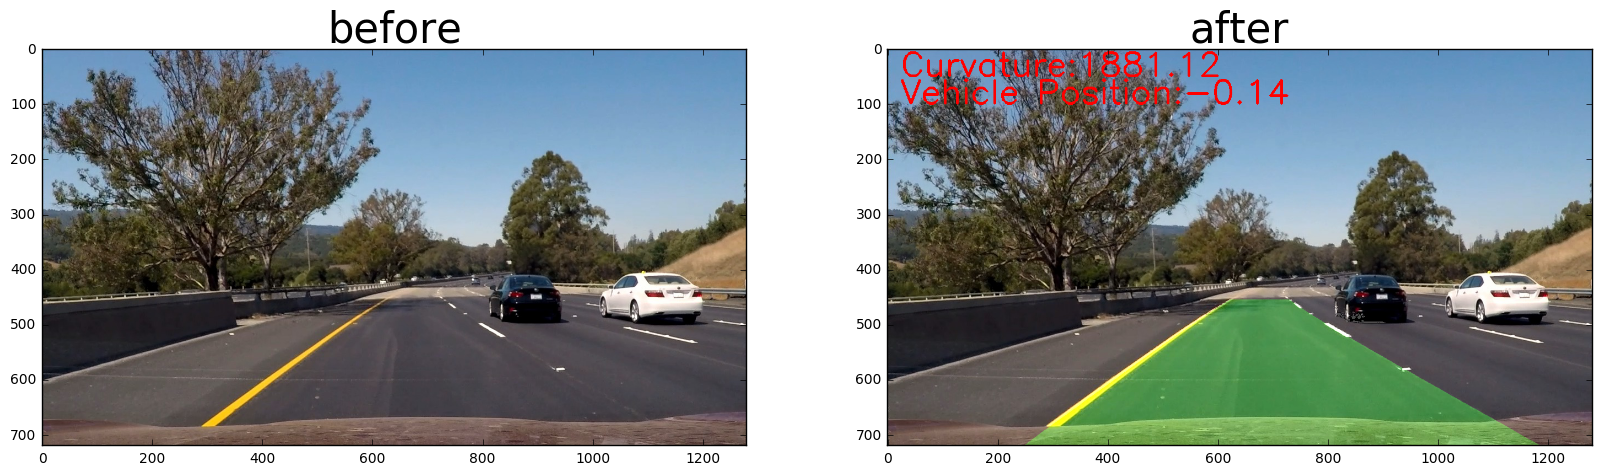

In [34]:
img = mpimg.imread('test_images/test6.jpg')
img_test = process_frame(img)
#img_test,M_inv = warp(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('before', fontsize=30)
ax2.imshow(img_test)
ax2.set_title('after', fontsize=30)

## Process video frames

In [ ]:
left_line = Line()
right_line = Line()

In [ ]:
project_test = 'project_output.mp4'
clip1 = VideoFileClip("project_calibrated.mp4");
output_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_test, audio=False);